In [3]:
import xarray as xr
import os
import oscarplus as op
import plot_helpers as ph
from oscarplus.processing.secondary_products import calculate_upwelling_SWT

# Making figures 1, 2 and 4

## Input parameters for plotting

In [4]:
# OSCAR
date = "20220517"
track = "2"
gmf = "mouche12kp20_rsv20"
# MARS
MARS2DTIME = "2022-05-17T09:30:00.000000000"
MARS3DTIME = "2022-05-17T09:00:00.000000000"
# plotting parameters
MARS2D_extent = [-5.18, -5.08, 48.368, 48.51]
MARS3D_extent = [
    MARS2D_extent[0] - 0.02,
    MARS2D_extent[1] + 0.02,
    MARS2D_extent[2] - 0.02,
    MARS2D_extent[3] + 0.02,
]

## Load and process data for single day plots and transects

In [5]:
# load bathymetry
bathymetry_path = op.tools.readers.get_data_dirs()["bathymetry"]
bathymetry = xr.open_mfdataset(
    os.path.join(bathymetry_path, "Iroise_Sea_Bathymetry_EMODnet.nc")
)  # change path to select a different file

# load OSCAR
OSCAR, _ = op.tools.readers.read_OSCAR(date, track, gmf, "L2a MF")
calculate_upwelling_SWT(OSCAR, -bathymetry["elevation"])  # add currentW to L2a_MF
OSCAR = op.tools.utils.cut_NaNs(OSCAR)

# load MARS2D
MARS2D = op.tools.readers.read_MARS2D(
    "MARC_L1-MARS2D-FINIS250_SEASTAREX_20220517.nc", 250
)
MARS2D_sub = MARS2D.sel(time=MARS2DTIME)
MARS2D_sub = op.tools.utils.cut_to_extent(MARS2D_sub, MARS2D_extent)
op.processing.secondary_products.calculate_secondary_products(MARS2D_sub)
calculate_upwelling_SWT(MARS2D_sub, -bathymetry["elevation"])  # add currentW to MARS2D

# load MARS3D
MARS3D = op.tools.readers.read_MARS3D(
    "MARC_F1-MARS3D-MANGAE2500_SEASTAREX_20220517.nc", 2500
)
MARS3D = MARS3D.sel(time=MARS3DTIME)
MARS3D = op.tools.utils.cut_to_extent(MARS3D, MARS3D_extent)
op.processing.secondary_products.calculate_secondary_products(MARS3D)

C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")


In [6]:
# Take transects
current_transect_north, elevation_transect_north = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=0,
    jCross=59,
    angle=225,
)
current_transect_south, elevation_transect_south = op.tools.utils.transect(
    OSCAR,
    bathymetry,
    iGround=10,
    jCross=19,
    angle=135,
)

## Make figures

Max velocity: 2.849035740832982
Divergence range: -34.30106755334558,27.914694850312614
Vertical velocity range: -0.2648135470685569,0.2631405599868695


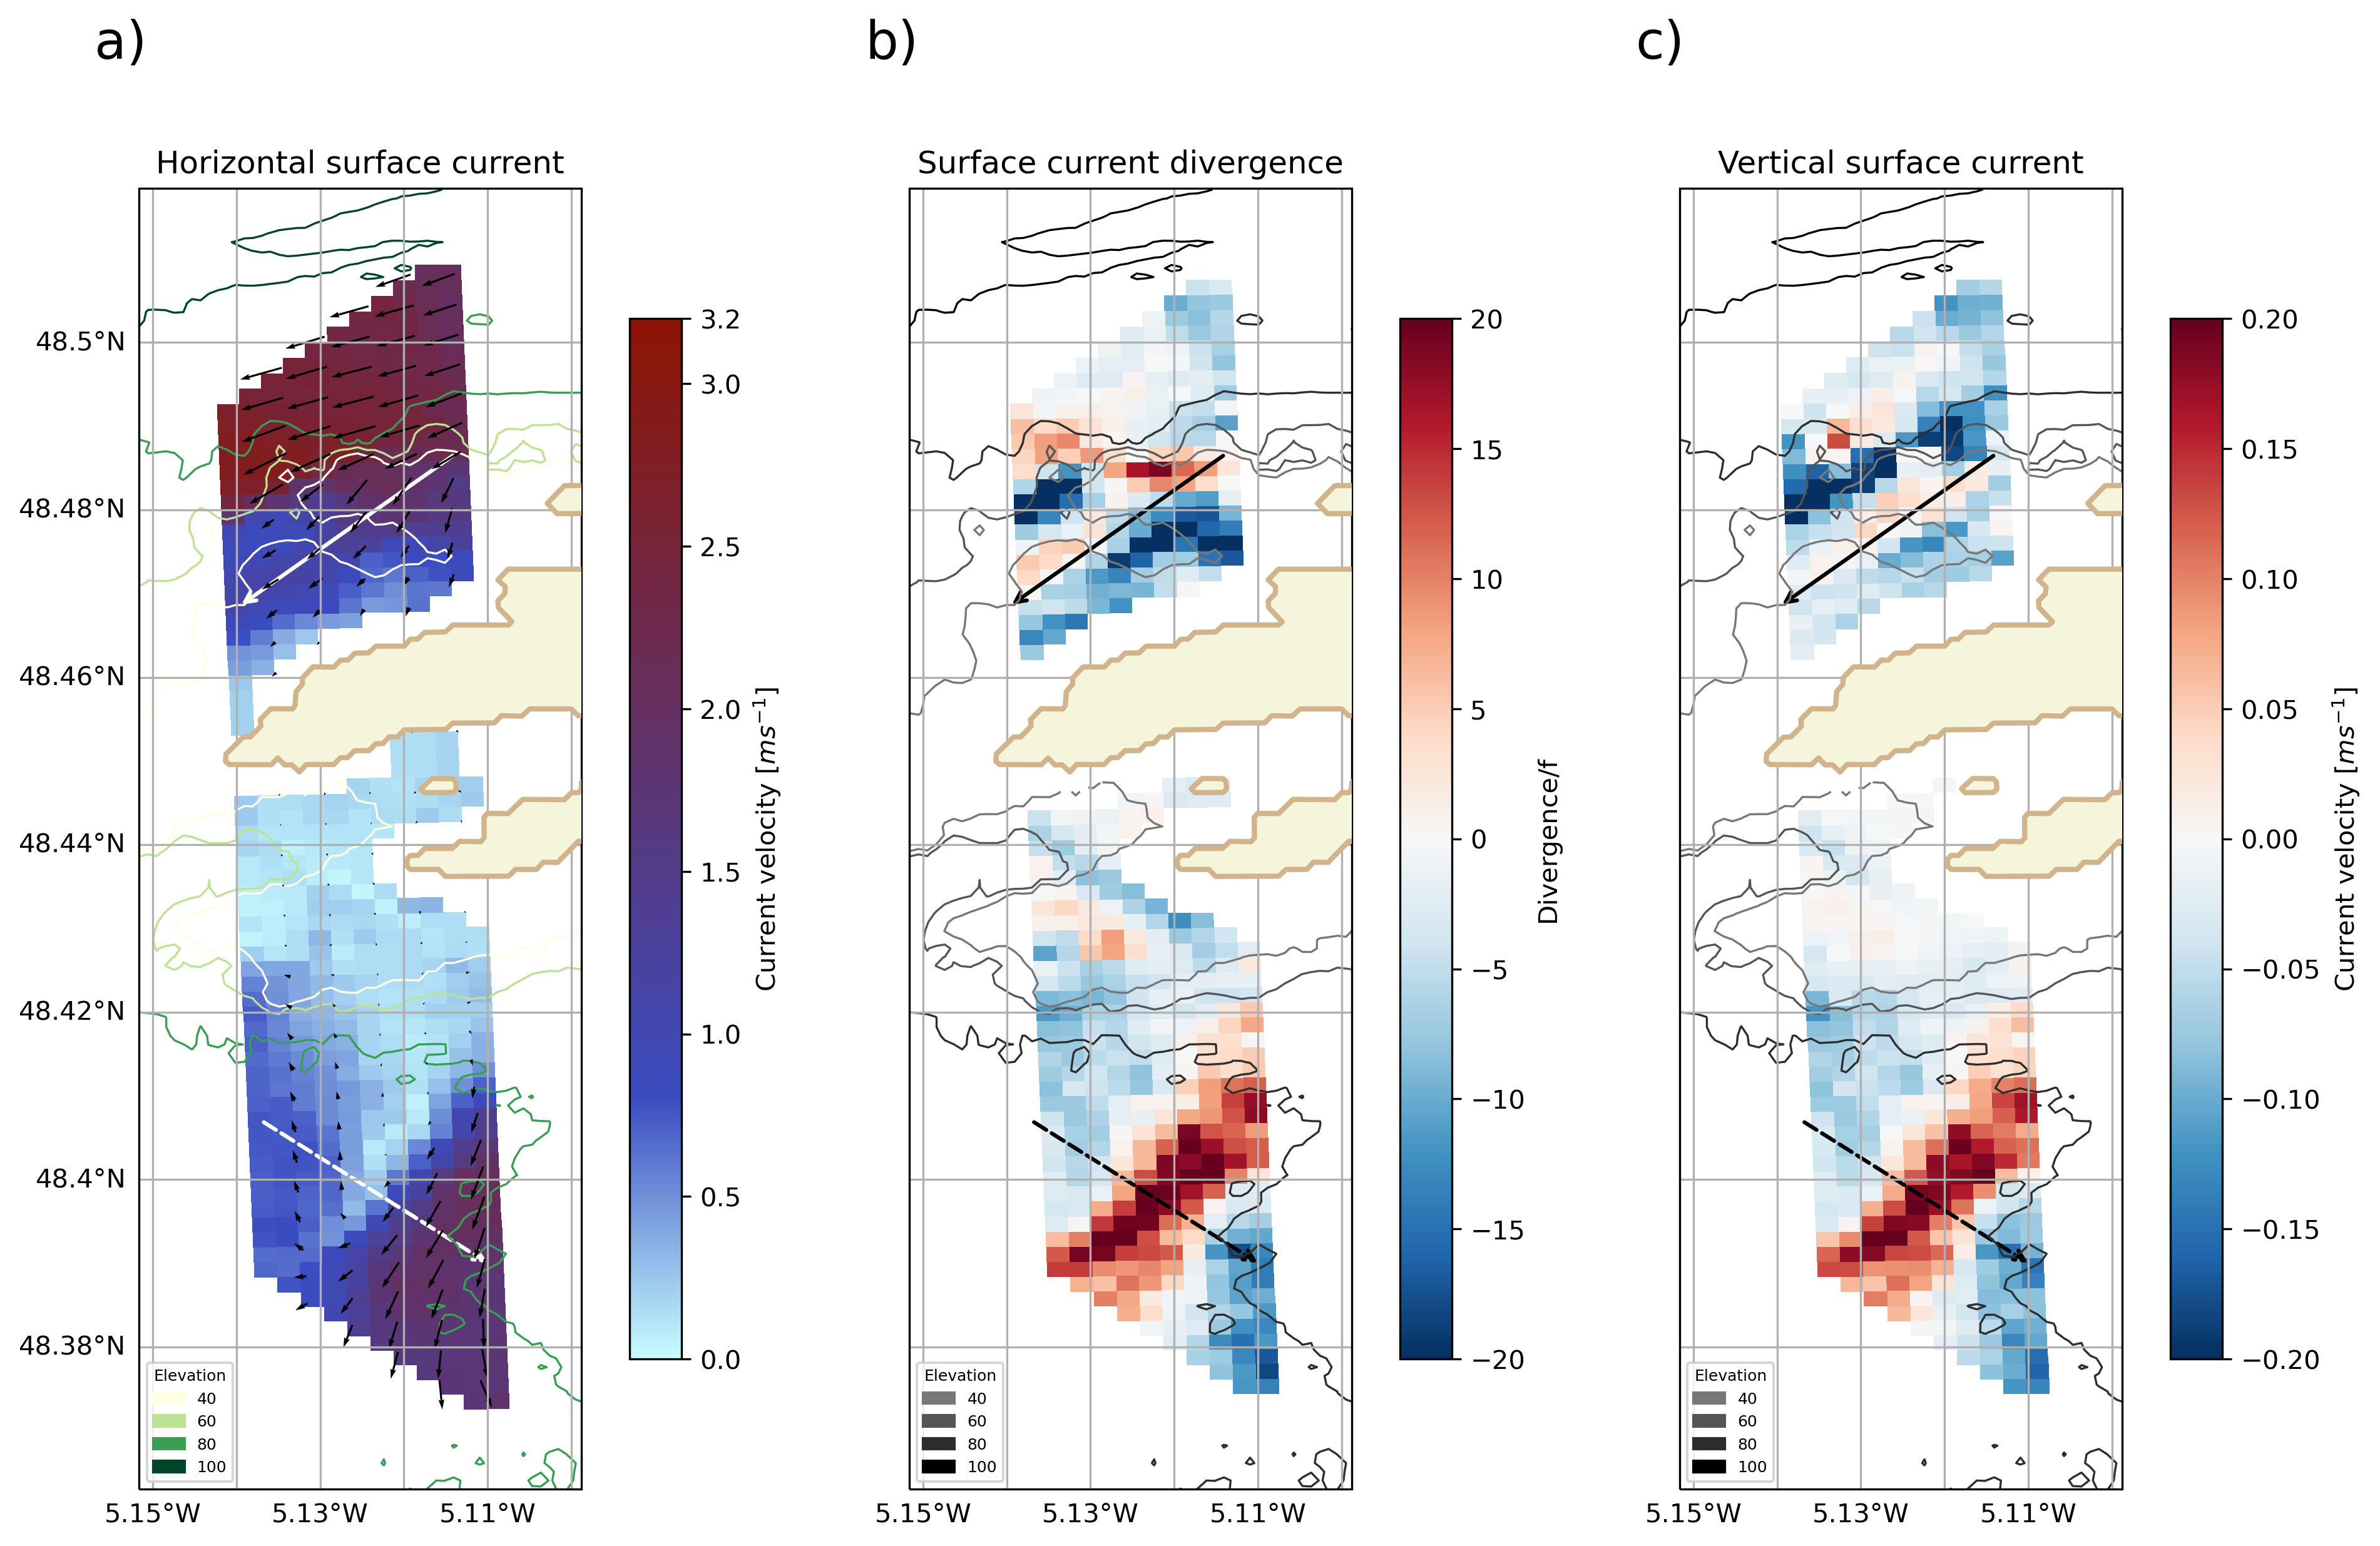

In [7]:
# plot figure 1
axes = ph.plot_all_three_on_one(
    DS=OSCAR,
    bathymetry=bathymetry,
    figsize=(15, 9),
    legend_location="lower left",
    xoffset=-0.01,
    yoffset=-0.01,
)

# find the coordinates of the transects
coordinates_north = ph.extract_transect_range(current_transect_north)
coordinates_south = ph.extract_transect_range(current_transect_south)

# add arrows
ph.add_arrow(axes[0], **coordinates_north, color="white", linewidth=1.5)
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_north, color="black", linewidth=1.5)

ph.add_arrow(axes[0], **coordinates_south, color="white", linewidth=1.5, linestyle="--")
for ax in axes[1:]:
    ph.add_arrow(ax, **coordinates_south, color="black", linewidth=1.5, linestyle="--")

ph.print_ranges(OSCAR)

Text(0.5, 1.0, 'Southern jet transect: divergence and vertical current')

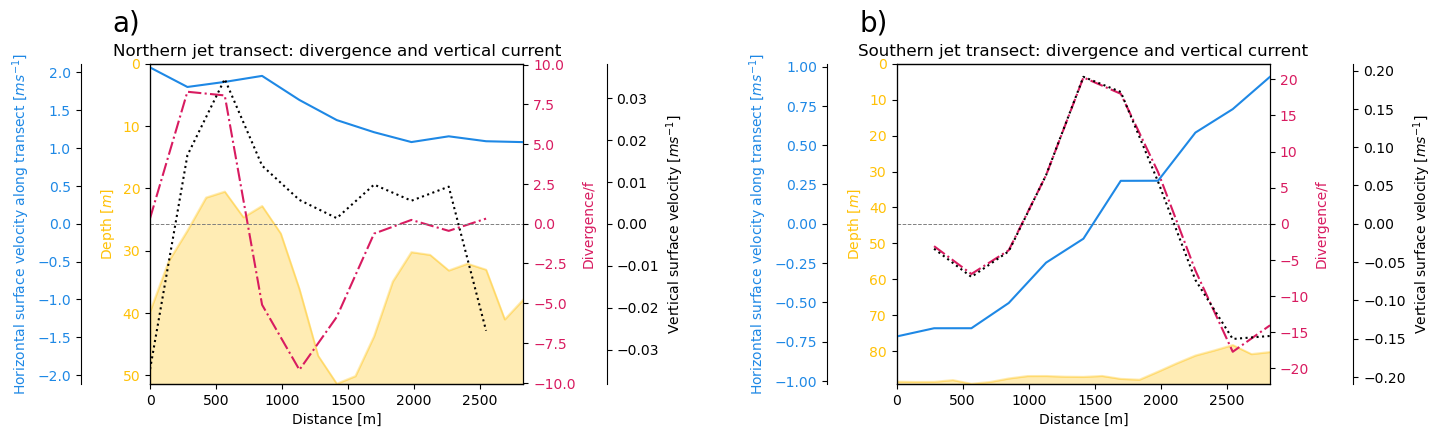

In [8]:
# plot figure 2
current_transects = [current_transect_north, current_transect_south]
elevation_transects = [elevation_transect_north, elevation_transect_south]
transect_axes = ph.plot_transects(
    current_transects, elevation_transects, figsize=(14, 4), symmetric_velocity=True,
)
# transect_axes[0].set_title("Northern jet transect: current velocity")
# transect_axes[1].set_title("Southern jet transect: current velocity")
transect_axes[0].set_title("Northern jet transect: divergence and vertical current")
transect_axes[1].set_title("Southern jet transect: divergence and vertical current")

In [9]:
MARS3D["level"]

<xarray.DataArray 'level' (level: 40)>
array([-0.9875, -0.9625, -0.9375, -0.9125, -0.8875, -0.8625, -0.8375, -0.8125,
       -0.7875, -0.7625, -0.7375, -0.7125, -0.6875, -0.6625, -0.6375, -0.6125,
       -0.5875, -0.5625, -0.5375, -0.5125, -0.4875, -0.4625, -0.4375, -0.4125,
       -0.3875, -0.3625, -0.3375, -0.3125, -0.2875, -0.2625, -0.2375, -0.2125,
       -0.1875, -0.1625, -0.1375, -0.1125, -0.0875, -0.0625, -0.0375, -0.0125],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-17T09:00:00
  * level    (level) float32 -0.9875 -0.9625 -0.9375 ... -0.0625 -0.0375 -0.0125
Attributes:
    long_name:           sigma level
    axis:                Z
    c_grid_axis_shift:   0.0
    positive:            up
    valid_min:           -1.0
    valid_max:           0.0
    standard_name:       ocean_s_coordinate
    formula_terms:       s: level eta: XE depth: H0 a: theta b: b depth_c: hc
    formula_definition:  z(n,k,j,i) = eta(n,j,i)*(1+s(k)) + depth_c*s(k) + (d...

In [10]:
print(op.tools.utils.find_closest_lon_lat(-5.12, 48.5, MARS3D))
print(op.tools.utils.find_closest_lon_lat(-5.09, 48.41, MARS3D))

(2, 7)
(3, 3)


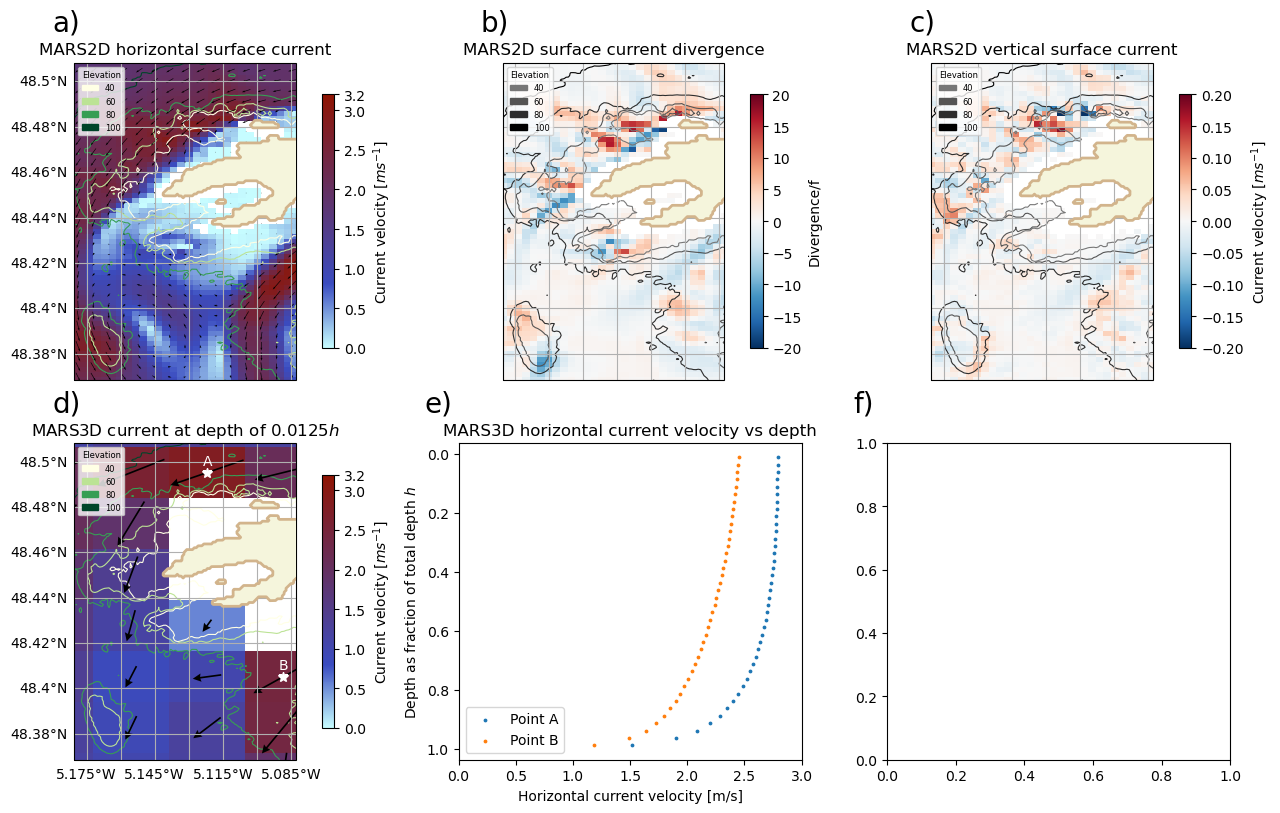

In [11]:
# plot figure 4
_ = ph.plot_MARS2D_and_MARS3D_profiles(
    MARS2D=MARS2D_sub,
    MARS3D=MARS3D,
    points=[(2, 7), (3, 3)],
    bathymetry=bathymetry,
    levels=[-0.0125, -0.6625, -0.9125],
    figsize=(15, 8.5),
    legend_location="upper left",
)

In [12]:
import subplots as splot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap

Bathymetrycmap = LinearSegmentedColormap.from_list(
    "Bathymetrycmap",
    [
        [0.0, "#777777"],
        [0.5, "#444444"],
        [1.0, "#000000"],
    ],
)

def MARS2D_through_time(
    MARS2Ds,
    bathymetry,
    figsize,
    extent,
    legend_location="upper right",
):
    _, axes = plt.subplots(
        2,
        3,
        subplot_kw={"projection": ccrs.PlateCarree()},
        gridspec_kw={"wspace": 0.2, "hspace": 0.007},
        figsize=figsize,
        dpi=300,
        constrained_layout=True,
    )

    depth = -bathymetry["elevation"]

    # TOP ROW
    cmaps = ["YlGn", Bathymetrycmap]

    gl_upper = []
    gl_lower = []

    for i in range(2):
        # Plot current
        gl_u = splot.quiver_with_background(
            MARS2Ds[i],
            ax=axes[0,i],
            selection="Current",
            title="MARS2D at " + str(MARS2Ds[2].time.dt.strftime('%H:%M').values),
            extent=extent,
            coarsen_arrows=True,
            vmax=3.2,
            add_cbar=False,
        )
        gl_upper.append(gl_u)
        # Plot divergence
        gl_l=splot.single(
            MARS2Ds[i]["CurrentDivergence"],
            ax=axes[1,i],
            extent=extent,
            title="MARS2D at " + str(MARS2Ds[2].time.dt.strftime('%H:%M').values),
            cbar_label="Divergence/f",
            vmax=20,
            add_cbar=False,
        )
        gl_lower.append(gl_l)

    # Plot current
    gl_upper.append(splot.quiver_with_background(
        MARS2Ds[2],
        ax=axes[0,2],
        selection="Current",
        title="MARS2D at " + str(MARS2Ds[2].time.dt.strftime('%H:%M').values),
        extent=extent,
        coarsen_arrows=True,
        vmax=3.2,
    ))
    # Plot divergence
    gl_lower.append(splot.single(
        MARS2Ds[2]["CurrentDivergence"],
        ax=axes[1,2],
        extent=extent,
        title="MARS2D at " + str(MARS2Ds[2].time.dt.strftime('%H:%M').values),
        cbar_label="Divergence/f",
        vmax=20,
    ))

        # Plot bathymetry
    for i in range(2):
        for j in range(3):
            splot.contours(
                depth,
                ax=axes[i,j],
                extent=extent,
                vmin=40,
                vmax=120,
                level_step=20,
                legend_title="Elevation",
                linewidths=0.8,
                legend_location=legend_location,
                cmap=cmaps[i],
            )
    for gl in gl_upper:
        gl.bottom_labels = False
    for i in range (1,3):
        gl_upper[i].left_labels = False
        gl_lower[i].left_labels = False
    plt.subplots_adjust(
        left=0.1, right=0.9, top=0.92, bottom=0.1, hspace=0.3, wspace=0.05
    )
    ph.add_letters(axes, y_pos=1.07)

    for i in range(3):
        axes[0,i].set_title(f"Current at {str(MARS2Ds[i].time.dt.strftime('%H:%M').values)}", fontsize=12)
        axes[1,i].set_title(f"Divergence at {str(MARS2Ds[i].time.dt.strftime('%H:%M').values)}", fontsize=12)

    return axes


C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\python_modules\oscarplus\tools\utils.py:661: UserWarning: EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF
  warnings.warn("EarthRelativeWindU and EarthRelativeWindV not found in L2_AR_MF")
C:\Users\arius\AppData\Local\Temp\ipykernel_34984\2197431925.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(


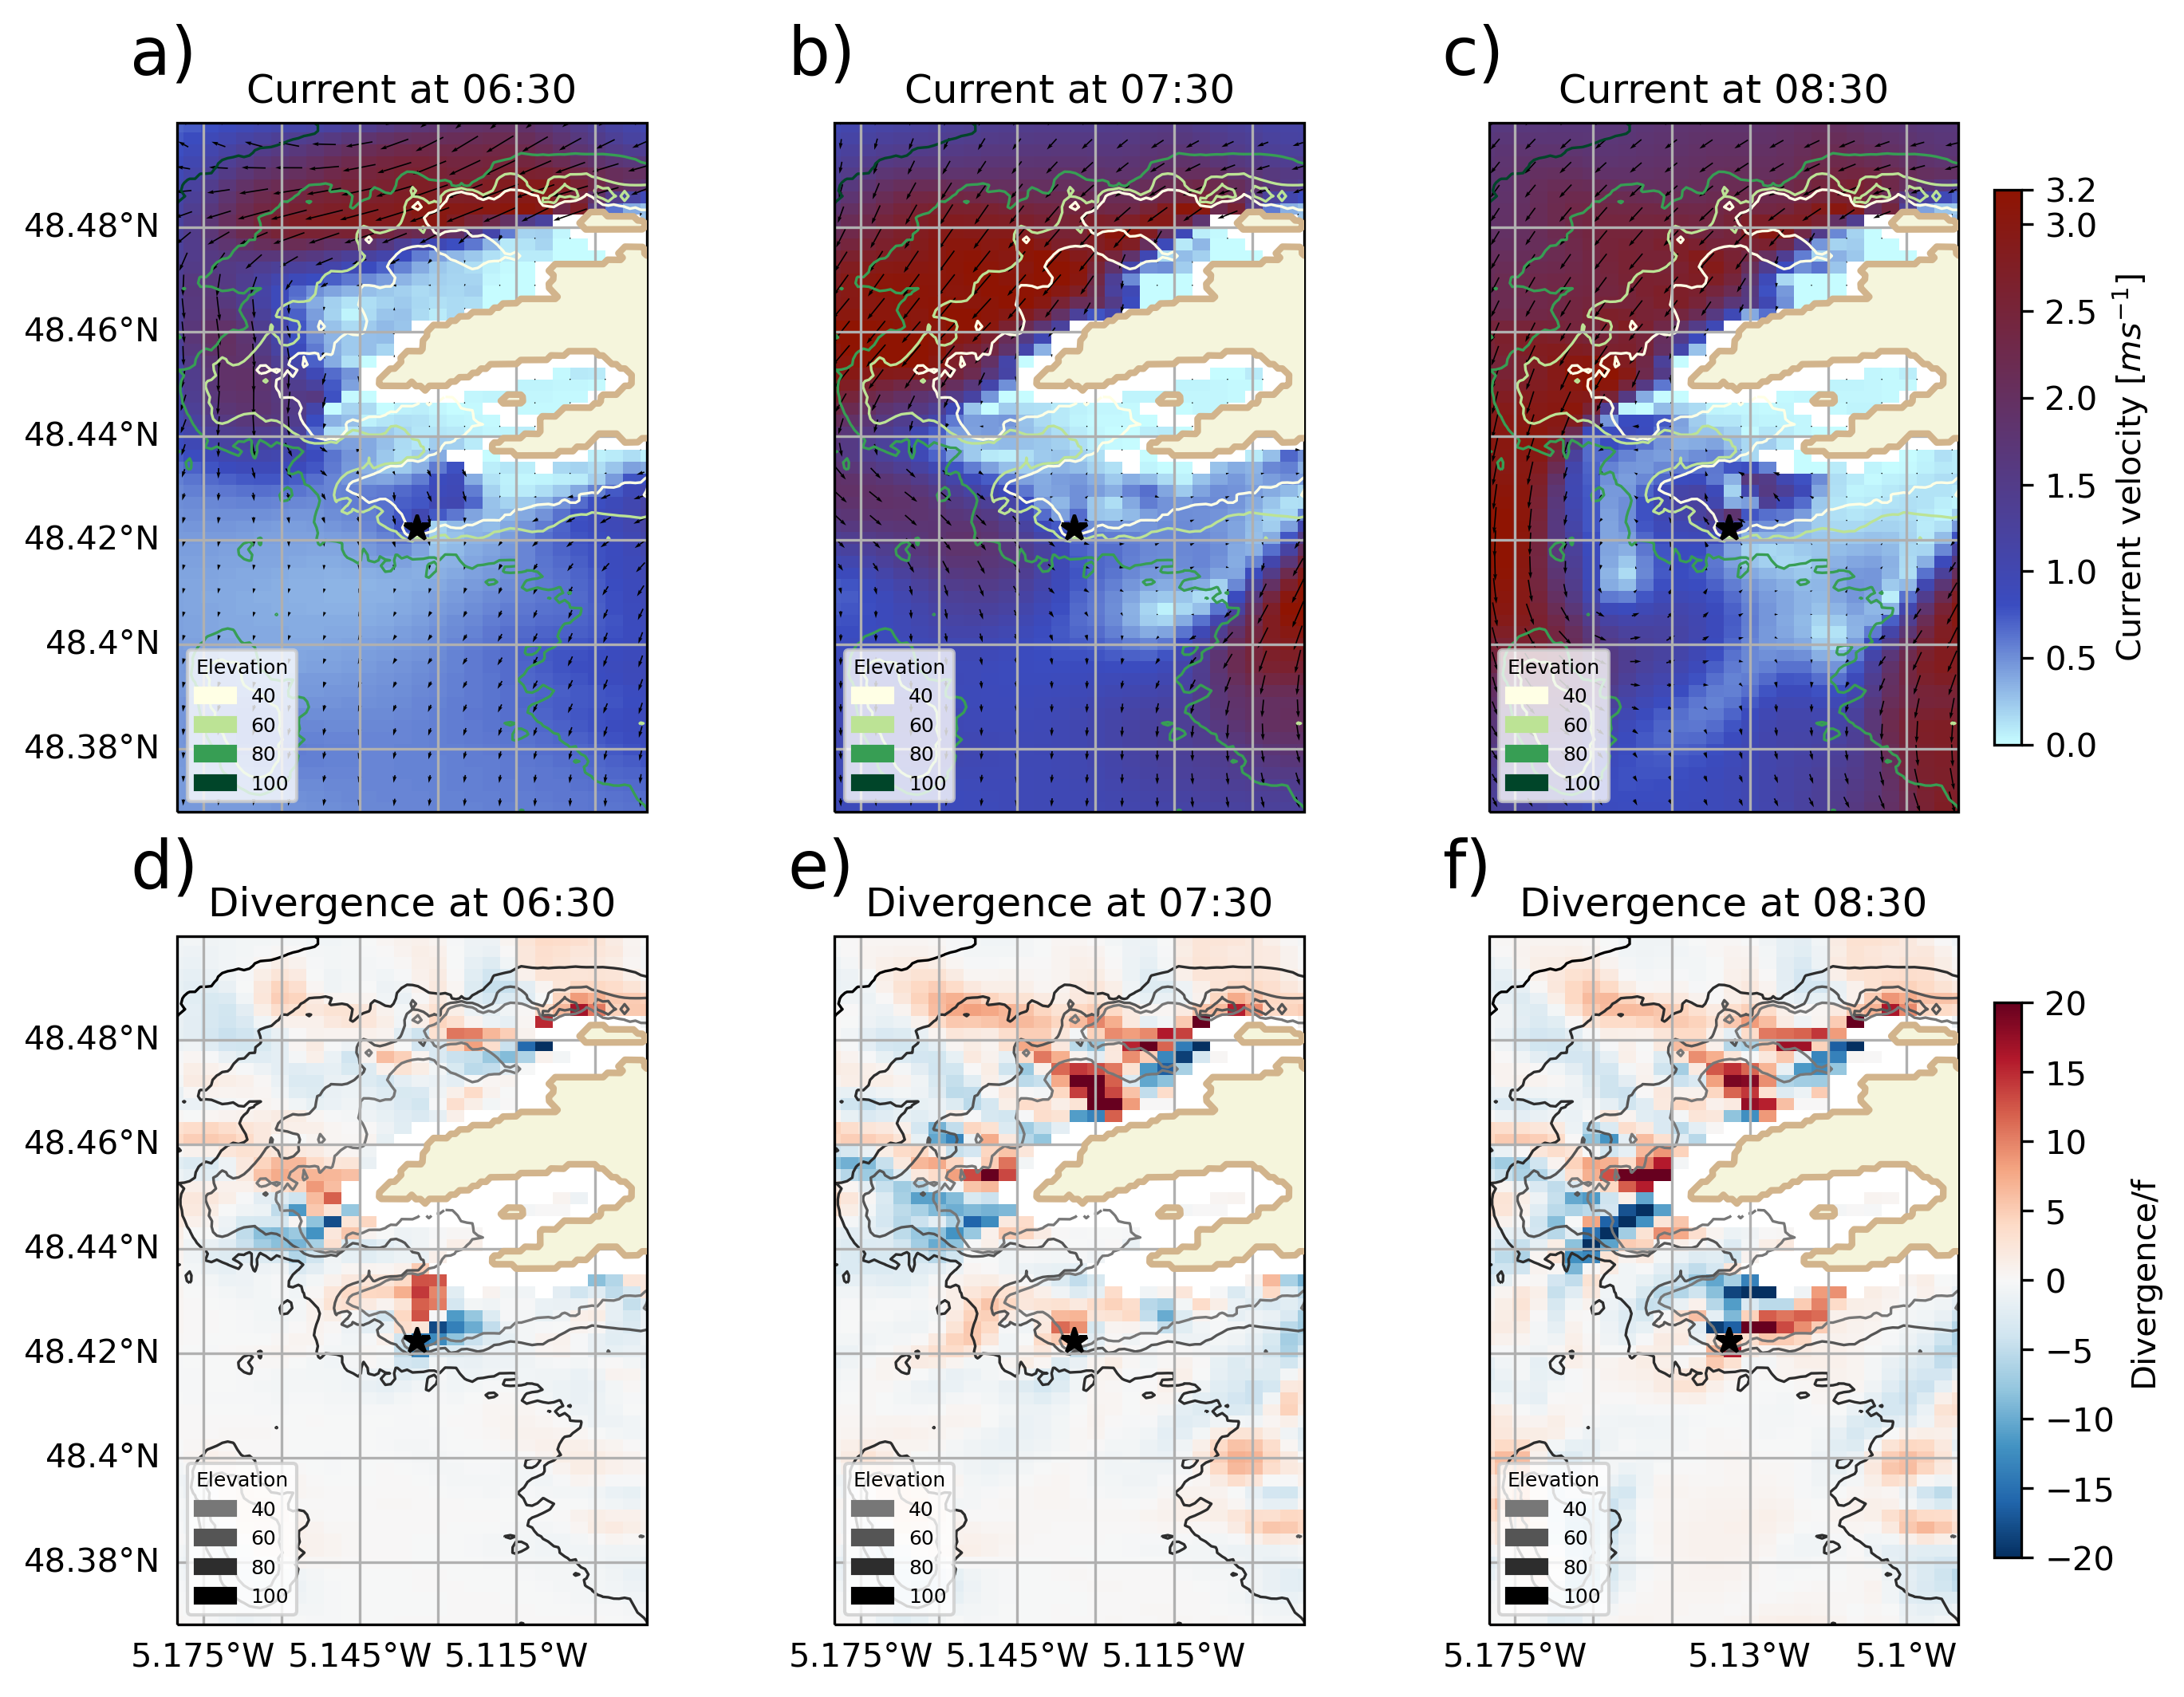

In [13]:
MARS2DTIMES = ["2022-05-17T06:30:00.000000000", "2022-05-17T07:30:00.000000000", "2022-05-17T8:30:00.000000000"]

MARS2Ds = []
for t in MARS2DTIMES:
    MARS2D_sub = MARS2D.sel(time=t)
    MARS2D_sub = op.tools.utils.cut_to_extent(MARS2D_sub, MARS2D_extent)
    op.processing.secondary_products.calculate_secondary_products(MARS2D_sub)
    MARS2Ds.append(MARS2D_sub)

extent = [-5.18, -5.09, 48.368, 48.5]

axes = MARS2D_through_time(
    MARS2Ds,
    bathymetry,
    figsize=(9, 7),
    legend_location="lower left",
    extent=extent,
)

for ax in axes.flatten(): 
    ax.plot(-5.13396667, 48.42222222, marker='*', color='black', markersize=8, transform=ax.projection, zorder=8)

In [14]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

In [15]:
# Prepare interpolator for bathymetry
lat_bathy = bathymetry['latitude'].values
lon_bathy = bathymetry['longitude'].values
elev_bathy = bathymetry['elevation'].values

interp = RegularGridInterpolator(
    (lat_bathy, lon_bathy),
    elev_bathy,
    bounds_error=False,
    fill_value=np.nan
)

# Get OSCAR coordinates
oscar_lat = OSCAR['latitude'].values
oscar_lon = OSCAR['longitude'].values

# Flatten coordinate arrays for interpolation
points = np.column_stack([oscar_lat.flatten(), oscar_lon.flatten()])
depth_oscar = -interp(points).reshape(oscar_lat.shape)  # negative elevation = depth

# Add depth to OSCAR dataset
OSCAR = OSCAR.assign(depth=(('CrossRange', 'GroundRange'), depth_oscar))

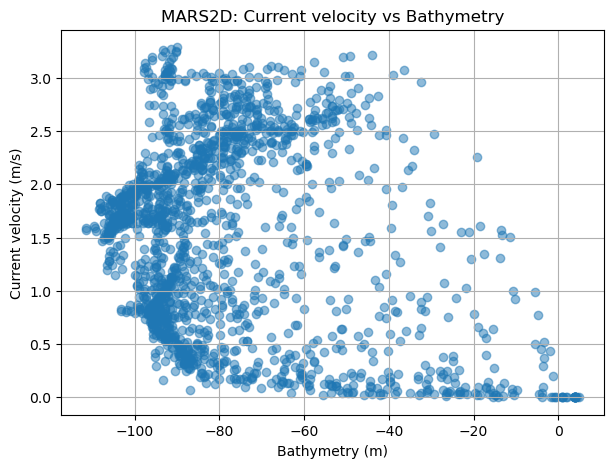

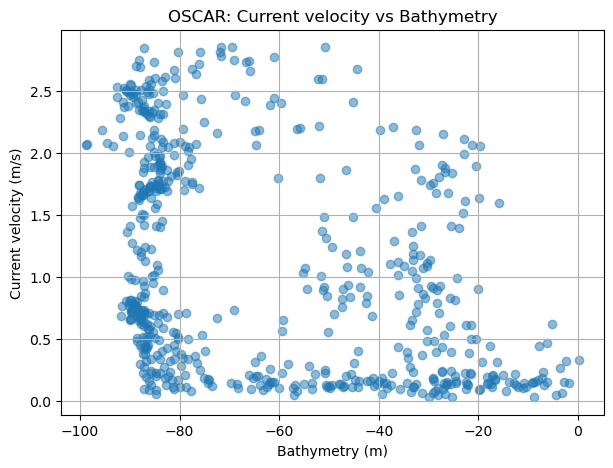

In [17]:
# Flatten arrays for scatterplot
velocity = MARS2D_sub["CurrentVelocity"].values.flatten()
depth = (-MARS2D_sub["H0"].values).flatten()

plt.figure(figsize=(7,5))
# Remove NaNs before plotting
mask = (~np.isnan(velocity)) & (~np.isnan(depth))
plt.scatter(depth[mask], velocity[mask], alpha=0.5)
plt.xlabel("Bathymetry (m)")
plt.ylabel("Current velocity (m/s)")
plt.title("MARS2D: Current velocity vs Bathymetry")
plt.grid(True)
plt.show()


# Flatten arrays for scatterplot
velocity = OSCAR["CurrentVelocity"].values.flatten()
depth = (-OSCAR["depth"].values).flatten()

plt.figure(figsize=(7,5))
# Remove NaNs before plotting
mask = (~np.isnan(velocity)) & (~np.isnan(depth))
plt.scatter(depth[mask], velocity[mask], alpha=0.5)
plt.xlabel("Bathymetry (m)")
plt.ylabel("Current velocity (m/s)")
plt.title("OSCAR: Current velocity vs Bathymetry")
plt.grid(True)
plt.show()

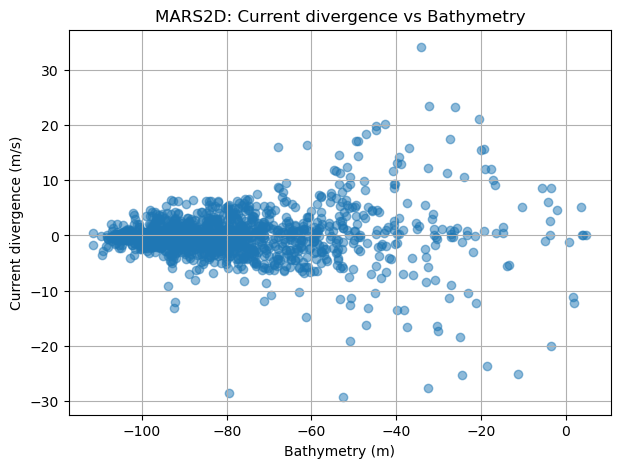

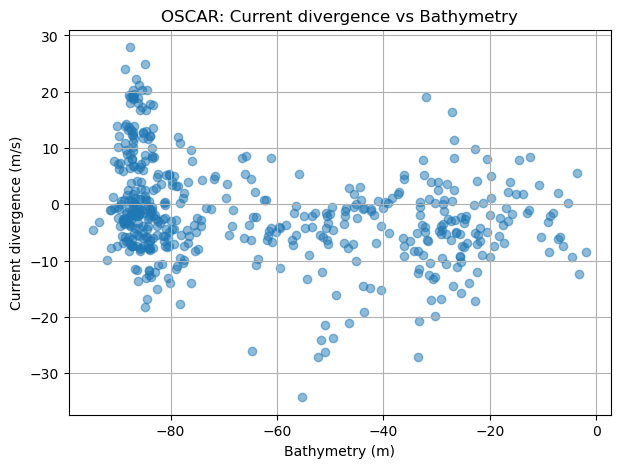

In [18]:
# Flatten arrays for scatterplot
divergence = MARS2D_sub["CurrentDivergence"].values.flatten()
depth = (-MARS2D_sub["H0"].values).flatten()

plt.figure(figsize=(7,5))
# Remove NaNs before plotting
mask = (~np.isnan(divergence)) & (~np.isnan(depth))
plt.scatter(depth[mask], divergence[mask], alpha=0.5)
plt.xlabel("Bathymetry (m)")
plt.ylabel("Current divergence (m/s)")
plt.title("MARS2D: Current divergence vs Bathymetry")
plt.grid(True)
plt.show()


# Flatten arrays for scatterplot
divergence = OSCAR["CurrentDivergence"].values.flatten()
depth = (-OSCAR["depth"].values).flatten()

plt.figure(figsize=(7,5))
# Remove NaNs before plotting
mask = (~np.isnan(divergence)) & (~np.isnan(depth))
plt.scatter(depth[mask], divergence[mask], alpha=0.5)
plt.xlabel("Bathymetry (m)")
plt.ylabel("Current divergence (m/s)")
plt.title("OSCAR: Current divergence vs Bathymetry")
plt.grid(True)
plt.show()